# Online Exposure Time Calculator Forecasts

Studies and plots to accompany [DESI-doc-1100](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=1100). The document is maintained as `doc/nb/ETC Calculator.ipynb` in the [desietc](https://github.com/desihub/desietc) package.

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.patches as mpatches
from matplotlib.collections import EllipseCollection

In [3]:
import scipy.linalg
import scipy.interpolate

In [4]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord,EarthLocation,AltAz,ICRS
from astropy.wcs import WCS

Update IERS data to avoid warnings about inaccurate polar motions.

In [5]:
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, cache=True))

In [6]:
import galsim

## Configuration

In [7]:
kpno = EarthLocation.from_geodetic(lat='31d57m48s', lon='-111d36m0s', height=2120.*u.m)

## Focal Plane Coordinates

In [8]:
def init_pointing(alt0,az0):
    if not isinstance(alt0,np.ndarray) and not isinstance(az0,np.ndarray):
        alt0,az0 = np.array((alt0,)),np.array((az0,))
        unpack = True
    else:
        unpack = False
    assert alt0.shape == az0.shape,'alt0 and az0 must have the same length.'
    assert len(alt0.shape) == 1,'alt0 and az0 must be 1D arrays.'
    return alt0,az0,unpack

In [9]:
def fp_to_altaz(x,y,alt0,az0):
    """
    Convert (x,y) vectors to alt,az angles.
    """
    assert x.shape == y.shape,'x and y have different shapes.'
    alt0,az0,unpack = init_pointing(alt0,az0)
    # Convert (x,y) to unit vectors.
    v = np.array((x,np.sqrt(1-x**2-y**2),y))
    # Build combined rotation matrices R[-alt0,x].R[+az0,z].
    R = np.empty(shape=[3,3]+list(alt0.shape))
    cos_alt0 = np.cos(alt0)
    sin_alt0 = np.sin(alt0)
    cos_az0 = np.cos(az0)
    sin_az0 = np.sin(az0)
    zero = np.zeros_like(alt0)
    R[0] = (cos_az0,cos_alt0*sin_az0,-sin_alt0*sin_az0)
    R[1] = (-sin_az0,cos_alt0*cos_az0,-cos_az0*sin_alt0)
    R[2] = (zero,sin_alt0,cos_alt0)
    # Transform v to u.
    u = np.einsum('ijn...,j...->in...',R,v)
    # Convert unit vectors to (alt,az).
    alt = np.arcsin(u[2])
    az = np.arctan2(u[0],u[1])
    if unpack:
        alt,az = alt[0],az[0]
    return alt,az

In [10]:
def altaz_to_fp(alt,az,alt0,az0):
    """
    Convert (alt,az) vectors to focal plane coordinates.
    
    Input arrays alt and az of targets must have the same shape ST, and input arrays
    alt0 and az0 of boresights must have the same shape SB.  The result is a an array
    of shape (ST,SB,2).
    
    Args:
        alt(numpy.ndarray): Array of target altitudes in radians above the horizon.
        az(numpy.ndarray): Array of target azimuthal angles in radians east of north.
        alt0(numpy.ndarray): Array of boresight altitudes in radians above the horizon.
        az0(numpy.ndarray): Array of boresight azimuthal angles in radians east of north.
        
    Returns:
        numpy.ndarray: Array of shape (ST,SB,2) of focal plane coordinates (x,y) in radians,
        with +x along the azimuth direction (increasing eastwards) and +y along the altitude
        direction (increasing towards zenith).
    """
    assert alt.shape == az.shape,'alt and az have different shapes.'
    alt0,az0,unpack = init_pointing(alt0,az0)
    # Convert (alt,az) to unit vectors.
    cos_alt = np.cos(alt)
    u = np.array((np.sin(az)*cos_alt,np.cos(az)*cos_alt,np.sin(alt)))
    # Build combined rotation matrices R[-alt0,x].R[+az0,z].
    R = np.empty(shape=[3,3]+list(alt0.shape))
    cos_alt0 = np.cos(alt0)
    sin_alt0 = np.sin(alt0)
    cos_az0 = np.cos(az0)
    sin_az0 = np.sin(az0)
    zero = np.zeros_like(alt0)
    R[0] = (cos_az0,-sin_az0,zero)
    R[1] = (cos_alt0*sin_az0,cos_alt0*cos_az0,sin_alt0)
    R[2] = (-sin_alt0*sin_az0,-cos_az0*sin_alt0,cos_alt0)
    # Transform u to v.
    v = np.einsum('ijn...,j...->in...',R,u)
    # Convert unit vectors to (x,y).
    x,y = v[0],v[2]
    if unpack:
        x,y = x[0],y[0]
    return x,y

Fiber diameter is 80 microns.

In [11]:
class Observation(object):
    """
    Represents a telescope observation.
    """
    def __init__(self,when,boresight_alt=60*u.deg,boresight_az=120*u.deg,guided=True,fiber_diameter=1.46*u.arcsec,
                 wavelength=5400*u.angstrom,linear_fov=3.2*u.deg,exp_time=30*u.min,nt=11,nxy=11,where=kpno):
        #
        # A datestring for when will be interpreted as UTC.
        self.when = Time(when)
        self.nt = nt
        self.nxy = nxy
        self.fiber_diameter = fiber_diameter
        config = dict(obswl=wavelength,location=where,pressure = 80*u.kPa,temperature = 15*u.deg_C)
        # Calculate the boresight ra,dec at the nominal observing time.
        self.boresight = AltAz(alt=boresight_alt,az=boresight_az,obstime=when,**config).transform_to(ICRS())
        # Calculate time steps during the exposure.
        assert nt%2 == 1,'nt must be an odd integer.'
        self.tvec = self.when + np.linspace(-0.5*exp_time,+0.5*exp_time,nt)
        self.dt_min = (self.tvec - self.when).to(u.min).value
        # Calculate the alt,az path of the nominal boresight ra,dec during the exposure.
        path0 = self.boresight.transform_to(AltAz(obstime=self.tvec,**config))
        alt0,az0 = path0.alt.to(u.rad).value,path0.az.to(u.rad).value
        # Calculate the focal plane rotation required for sidereal tracking.
        path1 = ICRS(ra=self.boresight.ra,dec=self.boresight.dec+1*u.deg).transform_to(
            AltAz(obstime=self.tvec,**config))
        alt1,az1 = path1.alt.to(u.rad).value,path1.az.to(u.rad).value
        self.tracking = np.empty((self.nt,))
        for it in range(self.nt):
            x1,y1 = altaz_to_fp(alt1[it],az1[it],alt0[it],az0[it])
            self.tracking[it] = np.arctan2(y1,x1)
        self.tracking -= self.tracking[self.nt//2]
        # Make an x,y fiber grid in the focal plane, in units of radians relative to the boresight,
        # with y increasing with altitude and x increasing eastwards with azimuth.
        xy_grid = np.linspace(-0.5,0.5,nxy)*linear_fov.to(u.rad).value
        self.x_fiber,self.y_fiber = np.meshgrid(xy_grid,xy_grid)
        # Calculate the ra,dec of the grid points at the nominal time.
        alt_target,az_target = fp_to_altaz(self.x_fiber,self.y_fiber,
            boresight_alt.to(u.rad).value,boresight_az.to(u.rad).value)
        targets = AltAz(alt=alt_target*u.rad,az=az_target*u.rad,obstime = when,**config).transform_to(ICRS())
        self.ra_target = targets.ra.to(u.rad).value
        self.dec_target = targets.dec.to(u.rad).value
        self.x_target = np.empty((nt,nxy,nxy))
        self.y_target = np.empty((nt,nxy,nxy))
        self.guiding = np.zeros((nt,4))
        # Loop over time steps during the exposure.
        for it in range(nt):
            # Calculate alt,az of of the target grid at each time step during the exposure.
            targets = SkyCoord(ra=self.ra_target*u.rad,dec=self.dec_target*u.rad,frame='icrs').transform_to(
                AltAz(obstime=self.tvec[it],**config))
            alt_target,az_target = targets.alt.to(u.rad).value,targets.az.to(u.rad).value
            self.x_target[it],self.y_target[it] = altaz_to_fp(alt_target,az_target,alt0[it],az0[it])
            if guided:
                # We currently use all fibers, but this could be done on a subset instead.
                #mask = (self.y_fiber*u.rad).to(u.deg) > 1.5*u.deg
                mask = np.ones_like(self.x_fiber,dtype=bool)
                # Find the the scale,rotation and offset that minimizes the residuals between the
                # targets and fibers.
                self.guiding[it] = self.guide(self.x_fiber[mask],self.y_fiber[mask],
                        self.x_target[it][mask],self.y_target[it][mask])
                # Apply guiding corrections to all fibers.
                self.x_target[it],self.y_target[it] = self.correct(self.x_target[it],self.y_target[it],*self.guiding[it])
        # Calculate centroid offsets in arcsecs.
        rad2arcsec = (1*u.rad).to(u.arcsec).value
        self.offset_arcsecs = rad2arcsec*np.sqrt((self.x_target-self.x_fiber)**2+(self.y_target-self.y_fiber)**2)

    def guide(self,x0,y0,x,y):
        """
        Find the scale,rotation and offset that minimizes the residuals between the transformed x,y and x0,y0.
        """
        assert x0.shape == y0.shape,'x0,y0 have different shapes.'
        assert x.shape == y.shape,'x,y have different shapes.'
        assert x0.shape == x.shape,'x0,y0 have different shape from x,y.'
        xy0 = np.concatenate([x0.flat,y0.flat])
        x = x.flatten()
        y = y.flatten()
        xy = np.concatenate([x,y])
        n = len(xy)
        A = np.empty((n,4))
        for i in range(n//2):
            A[i,:] = (x[i],-y[i],1.,0.)
            A[n//2+i,:] = (y[i],x[i],0.,1.)
        params,xy_residuals,rank,sing = scipy.linalg.lstsq(A,xy0)
        scale = np.sqrt(params[0]**2+params[1]**2)
        rotation = np.arctan2(params[1],params[0])
        dx,dy = params[2:]
        return scale,rotation,dx,dy
    
    def correct(self,x,y,scale,rotation,dx,dy):
        scos = scale*np.cos(rotation)
        ssin = scale*np.sin(rotation)
        return (scos*x - ssin*y + dx,ssin*x + scos*y + dy)

    def plot_grid(self,zoom=1500,cmap='bwr',save=None):
        fig = plt.figure(figsize=(8,7))
        fibers = [ ]
        for ix in range(self.nxy):
            for iy in range(self.nxy):
                x_zoom = self.x_fiber[ix,iy] + zoom*(self.x_target[:,ix,iy]-self.x_fiber[ix,iy])
                y_zoom = self.y_fiber[ix,iy] + zoom*(self.y_target[:,ix,iy]-self.y_fiber[ix,iy])
                plt.scatter(np.rad2deg(x_zoom),np.rad2deg(y_zoom),lw=0,s=5.,c=self.dt_min,cmap=cmap,alpha=0.75)
                if ix == 0 and iy == 0:
                    plt.colorbar(pad=0.02).set_label('$\Delta t$ (min)')
        # Draw outlines of each fiber with same zoom factor.
        r_fiber = 0.5*zoom*self.fiber_diameter.to(u.deg).value
        xy_fibers = np.vstack([np.rad2deg(self.x_fiber.flat),np.rad2deg(self.y_fiber.flat)]).T
        fibers = EllipseCollection(offsets = xy_fibers,units='x',transOffset=plt.gca().transData,
            widths=r_fiber,heights=r_fiber,angles=0.,facecolors='none',edgecolors='black',alpha=0.1)
        plt.gca().add_collection(fibers)
        plt.xlabel('Focal Plane X (deg)')
        plt.ylabel('Focal Plane Y (deg)')
        plt.axes().set_aspect('equal', 'datalim')
        plt.tight_layout();
        if save: plt.savefig(save)
    
    def plot_offsets(self):
        for ix in range(self.nxy):
            for iy in range(self.nxy):
                plt.scatter(self.dt_min,1e3*self.offset_arcsecs[:,ix,iy],s=1,alpha=0.5)
        plt.plot(self.dt_min,1e3*np.mean(self.offset_arcsecs,axis=(1,2)),'-',label='mean')
        plt.legend()
        plt.xlabel('$\Delta t$ (min)')
        plt.ylabel('Centroid offset (mas)')
        plt.ylim(0,None)
        
    def plot_guide_dxy(self):
        rad2mas = (1*u.rad).to(u.mas).value
        plt.plot(self.dt_min,rad2mas*self.guiding[:,2],'r-',label='$\Delta x$')
        plt.plot(self.dt_min,rad2mas*self.guiding[:,3],'b--',label='$\Delta y$')
        plt.legend(loc='upper center')
        plt.xlabel('$\Delta t$ (min)')
        plt.ylabel('Guider Offsets (mas)')
        plt.grid()
        
    def plot_guide_scale(self):
        plt.plot(self.dt_min,1e6*(self.guiding[:,0]-1))
        plt.xlabel('$\Delta t$ (min)')
        plt.ylabel('Guider Scale - 1 (ppm)')
        plt.grid()
        
    def plot_guide_rotation(self):
        # self.guiding[:,1] gives rotation of focal plane relative to +y increasing in altitude.
        # self.tracking gives rotation required for sidereal tracking.
        rad2arcsec = (1*u.rad).to(u.arcsec).value
        rotation = rad2arcsec*(self.tracking + self.guiding[:,1])
        plt.plot(p.dt_min,rotation)
        plt.xlabel('$\Delta t$ (min)')
        plt.ylabel('Guider Rotation (arcsec)')
        plt.grid()

In [12]:
p = Observation(when='2015-01-01',exp_time=60*u.min,boresight_alt=60*u.deg,boresight_az=30*u.deg)
print p.boresight

<ICRS Coordinate: (ra, dec) in deg
    (14.8239838, 55.59115552)>


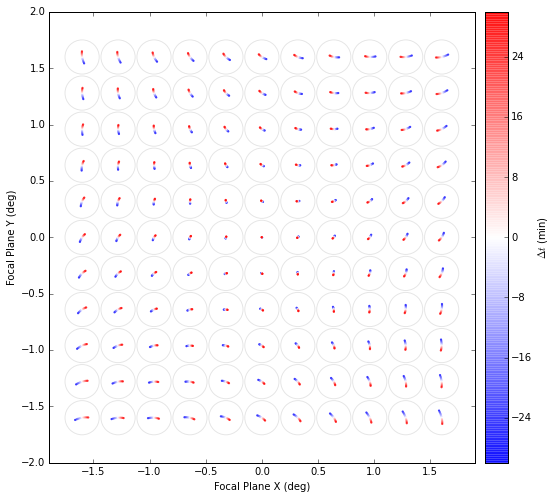

In [13]:
p.plot_grid()

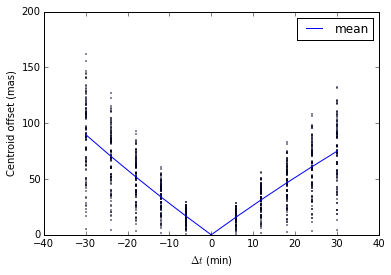

In [14]:
p.plot_offsets()

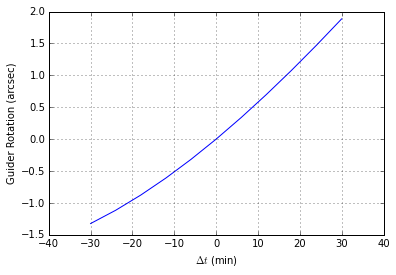

In [15]:
p.plot_guide_rotation()

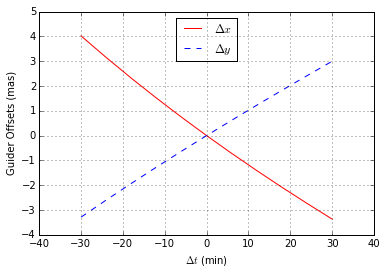

In [16]:
p.plot_guide_dxy()

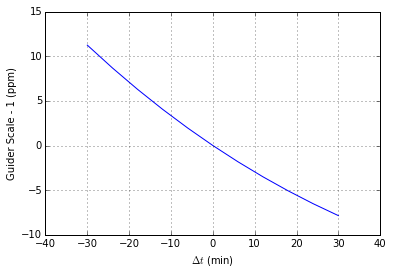

In [17]:
p.plot_guide_scale()

## Telescope Model

In [18]:
class Telescope(object):
    """
    Represents a telescope.
    """
    def __init__(self,diameter=3.80*u.m,obscuration_area_fraction=0.25,throughput=0.95*0.77,plate_scale=67.40*u.um/u.arcsec):
        self.diameter = diameter
        self.obscuration_area_fraction = obscuration_area_fraction
        self.throughput = throughput
        self.plate_scale = plate_scale
        self.effective_area = np.pi*diameter**2/4.*(1-obscuration_area_fraction)
    def get_optical_psf(self,wavelength):
        #Convert dimensionless lam/D to arcsec units.
        lam_over_diam_arcsec = ((wavelength/self.diameter)*u.rad).to(u.arcsec)
        # Airy requires floats as inputs, not numpy scalars.
        return galsim.Airy(lam_over_diam=float(lam_over_diam_arcsec.value),
            obscuration=float(np.sqrt(self.obscuration_area_fraction)))
    def get_atmospheric_psf(self,wavelength,fwhm5400):
        wlen_ratio = (wavelength/(5400*u.Angstrom)).si
        assert wlen_ratio == wlen_ratio.value,'wavelength has invalid units.'
        fwhm = fwhm5400.to(u.arcsec).value*wlen_ratio**(-0.2)
        # Kolmogorov requires floats as inputs, not numpy scalars.
        return galsim.Kolmogorov(fwhm=float(fwhm))
    def get_psf(self,wavelength,fwhm5400,rms_jitter=0.1*u.arcsec):
        components = [ self.get_atmospheric_psf(wavelength,fwhm5400),self.get_optical_psf(wavelength) ]
        # Include a Gaussian pointing jitter, if requested.
        if rms_jitter is not None:
            components.append(galsim.Gaussian(sigma = rms_jitter.to(u.arcsec).value))
        return galsim.Convolve(components)
    def plot_fwhm(self,wlen1,wlen2,fwhm5400,nwlen=50):
        wlen = np.linspace(wlen1,wlen2,nwlen)
        optical = np.empty_like(wlen)
        atmospheric = np.empty_like(wlen)
        for i in range(nwlen):
            print wlen[i]
            optical[i] = self.get_optical_psf(wlen[i]).getFWHM()
            atmospheric[i] = self.get_atmospheric_psf(wlen[i]).getFWHM()
        plt.plot(wlen.value,optical,'r-',label='Optical')
        plt.plot(wlen.value,atmospheric,'b-',label='Atmospheric')
        plt.legend()
        plt.xlabel('Wavelength (%s)',wlen.unit)
        plt.ylabel('FWHM (arcsec)')

In [19]:
t = Telescope()
t.effective_area*t.throughput

<Quantity 6.222038133168277 m2>

In [20]:
def calculate_fiber_acceptance(fiber_diameter,psf,sampling=100,max_offset=2):
    """
    Calculate the fiber acceptance fraction versus offset for a specified PSF.
    
    Args:
        fiber_diameter: Diameter of the fiber to use with explicit angular units.
        psf: PSF model to use, assumed to be specified in arcseconds.
        sampling: Sampling to use for the calculation. Higher samplings take longer
            but give more accurate results.
        max_offset: Maximum centroid offset to calculate, as a ratio of the
            fiber diameter.
    
    Returns:
        tuple: Tuple (offset,acceptance) where offset is given as a ratio of fiber
            diameter and acceptance is a fraction from 0-1.
    """
    # Render the PSF to an image with size fiber_diameter by (max_offset+1)*fiber_diameter.
    diam_arcsec = (fiber_diameter.to(u.arcsec)).value
    width = 2*sampling+1
    height = int(np.ceil((max_offset+1)*width))
    image = galsim.Image(width,height,scale=diam_arcsec/width)
    psf.shift(dx=0.,dy=-0.5*diam_arcsec*max_offset).drawImage(image=image)
    # Prepare a boolean mask of pixels falling inside the fiber aperture.
    xy = np.arange(width) - 0.5*(width-1)
    x,y = np.meshgrid(xy,xy)
    mask = (x**2 + y**2 < (0.5*width)**2)
    # Loop over centroid offsets.
    offset = np.arange(height-width+1)/float(width)
    acceptance = np.empty_like(offset)
    for dy in range(height-width):
        acceptance[dy] = np.sum(image.array[dy:dy+width]*mask)
    return offset,acceptance

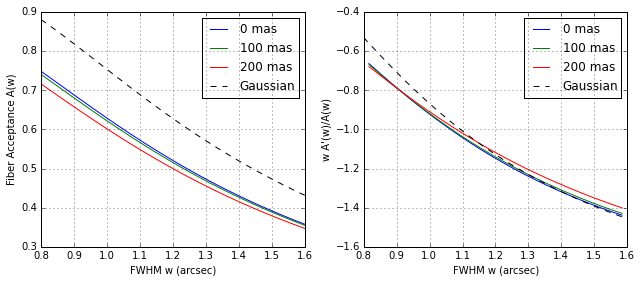

In [21]:
def plot_centered_acceptance(t,wlen=5400*u.Angstrom,D=1.46*u.arcsec,rms_jitter=0.1*u.arcsec,
                             fwhm_min=0.8,fwhm_max=1.6,num_fwhm=25,save=None):
    plt.figure(figsize=(9,4))
    fwhm_vec = np.linspace(fwhm_min,fwhm_max,num_fwhm)
    offsets_vec = np.array([0.,0.1,0.2])
    A_vec = np.empty((3,num_fwhm,))
    for i,fwhm in enumerate(fwhm_vec):
        psf = t.get_psf(wlen,fwhm*u.arcsec,rms_jitter = rms_jitter)
        offsets,acceptance = calculate_fiber_acceptance(D,psf)
        interpolator = scipy.interpolate.interp1d(offsets,acceptance)
        for j,offset in enumerate(offsets_vec):
            A_vec[j,i] = interpolator((offset*u.arcsec/D).si.value)
    #
    plt.subplot(1,2,1)
    for j,offset in enumerate(offsets_vec):
        plt.plot(fwhm_vec,A_vec[j],label=('%.0f mas'%(1e3*offset)))
    # Compare with Gaussian approximation
    fwhm_jitter_sq = 8*np.log(2)*rms_jitter**2
    A_gauss = 1 - np.power(2.,-D**2/((fwhm_vec*u.arcsec)**2+fwhm_jitter_sq))
    plt.plot(fwhm_vec,A_gauss,'k--',label='Gaussian')
    plt.legend()
    plt.grid()
    plt.xlim(fwhm_vec[0],fwhm_vec[-1])
    plt.xlabel('FWHM w (arcsec)')
    plt.ylabel('Fiber Acceptance A(w)')
    #
    plt.subplot(1,2,2)
    fwhm_fine = np.linspace(fwhm_min,fwhm_max,50)
    for j,offset in enumerate(offsets_vec):
        interpolator = scipy.interpolate.interp1d(fwhm_vec,A_vec[j])
        A = interpolator(fwhm_fine)
        dA = (A[2:] - A[:-2])/(fwhm_fine[2]-fwhm_fine[0])
        x = fwhm_fine[1:-1]*dA/A[1:-1]
        plt.plot(fwhm_fine[1:-1],x,label=('%.0f mas'%(1e3*offset)))
    w_tot_sq = (fwhm_fine*u.arcsec)**2+fwhm_jitter_sq
    x_gauss = 2*np.log(2)*D**2*(fwhm_fine*u.arcsec)**2/(1.-np.power(2.,D**2/w_tot_sq))/w_tot_sq**2
    plt.plot(fwhm_fine,x_gauss,'k--',label='Gaussian')
    plt.legend()
    plt.grid()
    plt.xlim(fwhm_vec[0],fwhm_vec[-1])
    plt.xlabel('FWHM w (arcsec)')
    plt.ylabel("w A'(w)/A(w)")
    #
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_centered_acceptance(t)#,save='acceptance.pdf')

Plot the acceptance variation with astmospheric FWHM at a fixed wavelength:

In [22]:
def plot_fwhm_acceptance(t,wlen=5400*u.Angstrom,D=1.46*u.arcsec,fwhm_min=0.8,fwhm_max=1.6,num_fwhm=5):
    plt.figure(figsize=(8,5))
    for fwhm in np.linspace(fwhm_min,fwhm_max,num_fwhm):
        psf = t.get_psf(wlen,fwhm*u.arcsec)
        offsets,acceptance = calculate_fiber_acceptance(D,psf)
        plt.plot(offsets,acceptance,label=('FWHM=%.1f"'%fwhm))
    plt.legend()
    plt.grid()
    plt.xlabel('Centroid Offset / Fiber Diameter')
    plt.ylabel('Fiber Acceptance')

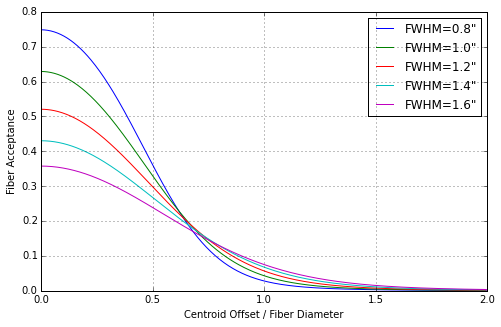

In [23]:
plot_fwhm_acceptance(t)

Plot the acceptance variation with wavelength at fixed astmospheric FWHM:

In [24]:
def plot_wlen_acceptance(t,fwhm=1.0*u.arcsec,D=1.46*u.arcsec,wlen1=3600*u.Angstrom,wlen2=9800*u.Angstrom,nwlen=3):
    plt.figure(figsize=(8,5))
    cmap = matplotlib.cm.ScalarMappable(
        matplotlib.colors.Normalize(vmin=wlen1.to(u.Angstrom).value,vmax=wlen2.to(u.Angstrom).value),'rainbow')
    for wlen in np.linspace(wlen1,wlen2,nwlen):
        wlen_Ang = wlen.to(u.Angstrom).value
        color = cmap.to_rgba(wlen_Ang)
        psf = t.get_psf(wlen,fwhm)
        offsets,acceptance = calculate_fiber_acceptance(D,psf)
        plt.plot(offsets,acceptance,label=('$\lambda$=%.0fA'%wlen_Ang),color=color)
        # Show atmospheric-only acceptance as dashed line in same color.
        psf = t.get_atmospheric_psf(wlen,fwhm)
        offsets,acceptance = calculate_fiber_acceptance(D,psf)
        plt.plot(offsets,acceptance,color=color,ls='--')
    plt.legend()
    plt.grid()
    plt.xlabel('Centroid Offset / Fiber Diameter')
    plt.ylabel('Fiber Acceptance')

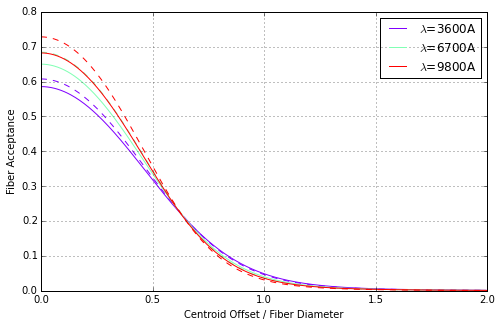

In [25]:
plot_wlen_acceptance(t)

## Guide Stars

In [26]:
class GFA(object):
    """
    Represents a GFA detector
    """
    def __init__(self,filter_midpt=645*u.nm,filter_bandwidth=0.16*u.um,filter_transmission=0.9,QE=0.9,pixel_size=15*u.um,
        rms_read_noise=20.0,dark_current=140.0/u.s):
        self.filter_midpt = filter_midpt
        self.throughput = QE*filter_transmission*filter_bandwidth
        self.pixel_size = pixel_size
        self.rms_read_noise = rms_read_noise
        self.dark_current = dark_current
        
    def observe(self,telescope,r_mag=18.0,ROI_size=20,exposure_time=0.5*u.s,
        atmospheric_transmission=0.76,FWHM5400=1*u.arcsec,mean_sky=546/(u.m**2*u.s*u.um*u.arcsec**2),verbose=True):

        # Calculate the conversion from photon flux entering the telescope to detected electrons.
        conversion = telescope.effective_area*telescope.throughput*self.throughput

        # Calculate the mean total signal flux in detected electrons.
        src_photons = (6.25e10/(u.m**2*u.s*u.um))*10**(-0.4*r_mag)*exposure_time
        src_electrons = src_photons*conversion*atmospheric_transmission
        assert src_electrons == src_electrons.value,(
            'Source electrons not dimensionless: %r' % src_electrons)
        
        # Calculate the mean sky flux in detected electrons per pixel.
        pixel_size = self.pixel_size/telescope.plate_scale
        if verbose:
            print 'Pixel size',pixel_size
        sky_electrons_per_pixel = mean_sky*exposure_time*conversion*pixel_size**2
        
        # Calculate the mean image centered in a ROI, with a random sub-pixel offset.
        pixel_size_arcsec = pixel_size.to(u.arcsec).value
        ROI = galsim.Image(ROI_size,ROI_size,scale = pixel_size_arcsec)
        dx0,dy0 = pixel_size_arcsec*np.random.uniform(low = -1,high = +1,size = 2)
        PSF = src_electrons.value*telescope.get_psf(self.filter_midpt,FWHM5400).shift(dx = dx0,dy = dy0)
        PSF.drawImage(image = ROI)
        
        # Calculate the corresponding inverse-variance image.
        noise_variance_per_pixel = self.rms_read_noise**2 + self.dark_current*exposure_time
        ivar_image = 1./(ROI.array + sky_electrons_per_pixel + noise_variance_per_pixel)
        
        # Fill an array of finite-difference images for variations in flux,x,y,FWHM4500.
        plus = ROI.copy()
        minus = ROI.copy()
        partials = np.empty((4,ROI_size,ROI_size))
        # The flux variation image is just the normalized mean flux itself.
        partials[0] = ROI.array/src_electrons
        # Vary dx by +/- 1/3 pixel
        delta = 0.3*pixel_size_arcsec
        PSF.shift(dx = +delta,dy = 0).drawImage(image = plus)
        PSF.shift(dx = -delta,dy = 0).drawImage(image = minus)
        partials[1] = (plus.array - minus.array)/(2*delta)
        # Vary dy by +/- 1/3 pixel
        delta = 0.3*pixel_size_arcsec
        PSF.shift(dx = 0,dy = +delta).drawImage(image = plus)
        PSF.shift(dx = 0,dy = -delta).drawImage(image = minus)
        partials[2] = (plus.array - minus.array)/(2*delta)
        # Vary FWHM5400 by 0.05 arcsec.
        delta = 0.05*u.arcsec
        PSF = src_electrons.value*telescope.get_psf(self.filter_midpt,FWHM5400+delta).shift(dx = dx0,dy = dy0)
        PSF.drawImage(image = plus)
        PSF = src_electrons.value*telescope.get_psf(self.filter_midpt,FWHM5400-delta).shift(dx = dx0,dy = dy0)
        PSF.drawImage(image = minus)
        partials[3] = (plus.array - minus.array)/(2*delta.value)
        
        # Calculate the Fisher matrix for the parameters (flux,dx,dy,FWHM5400)
        npar = 4
        fisher = np.empty((npar,npar))
        for ipar in range(npar):
            for jpar in range(ipar,npar):
                fisher[ipar,jpar] = np.sum(partials[ipar]*partials[jpar]*ivar_image)
                if jpar > ipar:
                    fisher[jpar,ipar] = fisher[ipar,jpar]
        
        # Calculate the corresponding parameter covariance matrix.
        covariance = scipy.linalg.inv(fisher)
        
        # Calculate SNR assuming size and position are exactly known.
        snr0 = src_electrons*fisher[0,0]**0.5
        
        # Calculate SNR with flux error marginalized over unknown size and position.
        snr = src_electrons*covariance[0,0]**-0.5
        
        if verbose:
            # Compare with Kevin's S,N within EE50 disk.
            S50 = 0.5*src_electrons
            N50 = np.sqrt(S50+16*(noise_variance_per_pixel+sky_electrons_per_pixel))
            print 'S50=',S50,'N50=',N50,'SNR50=',S50/N50
            # Calculate Fisher SNR assuming position and size are exactly known.
            print 'SNR0=',snr0
            # Calculate Fisher SNR marginalized over position and size.
            print 'SNR=',snr
            # Print centroiding RMS errors.
            print 'Centroiding errors: %.1f , %.1f mas'%(1e3*fisher[1,1]**-0.5,1e3*fisher[2,2]**-0.5)
            print 'Centroiding errors: %.1f , %.1f mas'%(1e3*covariance[1,1]**0.5,1e3*covariance[2,2]**0.5)
            print 'SNR50/(2.35*FWHM) = %.1f mas' % (1e3*FWHM5400.to(u.arcsec).value/(2.35*S50/N50))
        
        return partials,covariance,snr0,snr

Pixel size 0.222551928783 arcsec
S50= 604.186877229 N50= 91.0968809455 SNR50= 6.63235525694
SNR0= 6.61335088914
SNR= 4.52917127615
Centroiding errors: 97.6 , 97.6 mas
Centroiding errors: 97.6 , 97.6 mas
SNR50/(2.35*FWHM) = 64.2 mas
ROI signal = 0.971649313095


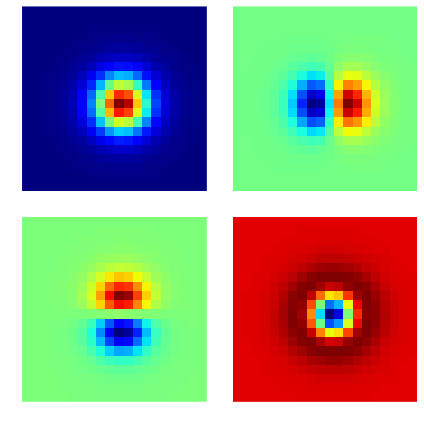

In [27]:
gfa = GFA(pixel_size=15*u.um)
partials,cov,snr0,snr = gfa.observe(t,ROI_size=20)
plt.figure(figsize=(6,6))
for i,img in enumerate(partials):
    plt.subplot(2,2,i+1)
    plt.imshow(img,interpolation='none',origin='lower',cmap='jet')
    plt.axis('off')
plt.tight_layout()
print 'ROI signal =',np.sum(partials[0])

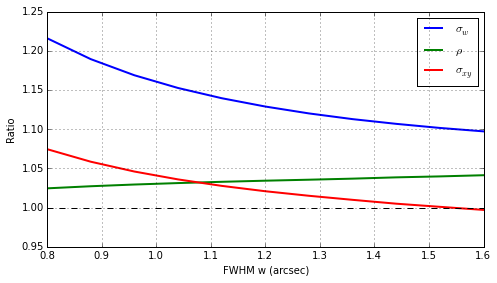

In [28]:
def plot_cov_vs_fwhm(gfa,telescope,fwhm_min=0.8,fwhm_max=1.6,num_fwhm=11,save=None):
    c = 8*np.log(2)
    fwhm_vec = np.linspace(fwhm_min,fwhm_max,num_fwhm)
    ratio_vec = np.empty((4,num_fwhm))
    for i,fwhm in enumerate(fwhm_vec):
        partials,cov,snr0,snr = gfa.observe(t,r_mag=18.,FWHM5400=fwhm*u.arcsec,verbose=False)
        ratio_vec[0,i] = snr0/snr
        ratio_vec[1,i] = np.sqrt(c*(cov[1,1]+cov[2,2])/2)*snr/fwhm
        ratio_vec[2,i] = np.sqrt(2*cov[3,3])*snr/fwhm
        ratio_vec[3,i] = np.sqrt(2)*cov[0,3]/np.sqrt(cov[0,0]*cov[3,3])
    #
    plt.figure(figsize=(7,4))
    ##plt.plot(fwhm_vec,ratio_vec[0],lw=2,label='$\\nu_0/\\nu$')
    plt.plot(fwhm_vec,ratio_vec[2],lw=2,label='$\sigma_w$')
    plt.plot(fwhm_vec,ratio_vec[3],lw=2,label='$\\rho$')
    plt.plot(fwhm_vec,ratio_vec[1],lw=2,label='$\sigma_{xy}$')
    plt.axhline(1.,ls='--',color='k')
    plt.legend(loc='best')
    plt.grid()
    ##plt.ylim(0.95,1.5)
    plt.xlabel('FWHM w (arcsec)')
    plt.ylabel('Ratio')
    #
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_cov_vs_fwhm(gfa,t)#,save='covariance.pdf')

## Background Estimates

In [29]:
def gfa_total_bg(temperature_C,exposure_time=0.5,sky_brightness=21.8):
    temperature_K = 273.15 + temperature_C
    dark_current = 19335.*temperature_K**3*np.exp(-6400./temperature_K)
    return (dark_current + sky_brightness)*exposure_time # per pixel per exposure

In [30]:
def bg_error_fraction(area_pixels,temperature_C,temperature_error,
                      exposure_time=0.5,sky_brightness=21.8,readout_noise=20.):
    total_bg = gfa_total_bg(temperature_C,exposure_time,sky_brightness) # per pixel per exposure
    temperature_K = 273.15 + temperature_C
    #temp_exp = np.exp(-6400./temperature_K)
    #dark_current = 19335.*temperature_K**3*temp_exp
    dark_current_deriv = exposure_time*(123744000.*temperature_K + 58005.*temperature_K**2)*np.exp(-6400./temperature_K)
    return np.sqrt((total_bg + readout_noise**2)/area_pixels +
        (dark_current_deriv*temperature_error)**2)/(sky_brightness*exposure_time)

In [31]:
def plot_bg_error(save=None):
    area_pixels = np.logspace(0.5,4.0,100)
    #
    plt.figure(figsize=(7,4))
    #
    frac = bg_error_fraction(area_pixels,30.,1.0)
    plt.plot(area_pixels,frac,'r',label='30 $^\circ$C')
    frac = bg_error_fraction(area_pixels,30.,0.1)
    plt.plot(area_pixels,frac,'r--')
    #
    frac = bg_error_fraction(area_pixels,20.,1.0)
    plt.plot(area_pixels,frac,'k',lw=1.5,label='20 $^\circ$C')
    frac = bg_error_fraction(area_pixels,20.,0.1)
    plt.plot(area_pixels,frac,'k--',lw=1.5)
    #
    frac = bg_error_fraction(area_pixels,10.,1.0)
    plt.plot(area_pixels,frac,'b',label='10 $^\circ$C')
    frac = bg_error_fraction(area_pixels,10.,0.1)
    plt.plot(area_pixels,frac,'b--')
    #
    plt.xlim(area_pixels[0],area_pixels[-1])
    plt.ylim(0.,2.0)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Background estimation area (pixels)')
    plt.ylabel('Background estimation error $\sigma_{B_i}/B_i$')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

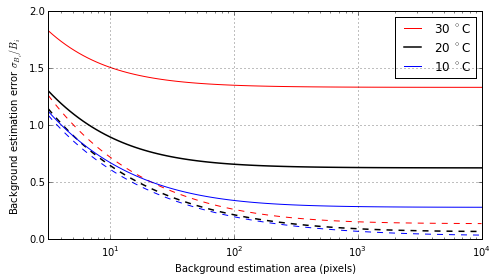

In [32]:
plot_bg_error()#'bg.pdf')

## Gaussian Model

In [33]:
def gaussian_fiber_acceptance(psf_fwhm_arcsec,rms_jitter_arcsec=0.1,fiber_diameter_arcsec=1.46):
    twolog2 = 2*np.log(2)
    return 1.-np.power(2.,-fiber_diameter_arcsec**2/(psf_fwhm_arcsec**2+4*twolog2*rms_jitter_arcsec**2))

In [34]:
def gaussian_error_fraction(snr,psf_fwhm_arcsec,rms_jitter_arcsec=0.1,fiber_diameter_arcsec=1.46,w0=1.0):
    twolog2 = 2*np.log(2)
    w_sq = psf_fwhm_arcsec**2
    w_tot_sq = w_sq + 4*twolog2*rms_jitter_arcsec**2
    D_sq = fiber_diameter_arcsec**2
    x = twolog2*D_sq*w_sq/(1.-np.power(2.,D_sq/w_tot_sq))/w_tot_sq**2
    return np.sqrt(1+0.5*x+0.5*x**2)/snr

In [35]:
def plot_gaussian_sig_error(save=None):
    w0 = 1.2 # arcsec
    snr0 = np.logspace(0.5,2.5,100)
    skyratio = np.sqrt(1./0.75)
    #
    plt.figure(figsize=(7,4))
    #
    w = 1.6
    frac = gaussian_error_fraction(snr0*w0/w,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'b',label='%.1f"' % w)
    frac = gaussian_error_fraction(snr0*w0/w*skyratio,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'b--')
    w = 1.2
    frac = gaussian_error_fraction(snr0*w0/w,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'k',label='%.1f"' % w)
    frac = gaussian_error_fraction(snr0*w0/w*skyratio,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'k--')
    w = 0.8
    frac = gaussian_error_fraction(snr0*w0/w,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'r',label='%.1f"' % w)
    frac = gaussian_error_fraction(snr0*w0/w*skyratio,psf_fwhm_arcsec=w)
    plt.plot(snr0,frac,'r--')
    #
    plt.xlim(snr0[0],snr0[-1])
    plt.ylim(0,0.25)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Guide star total SNR per exposure (FHWM=1.2",nominal sky)')
    plt.ylabel('Signal estimation error $\sigma_{S_i}/S_i$')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

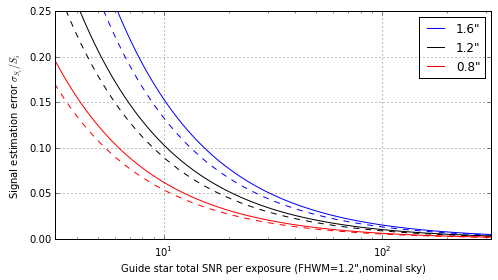

In [36]:
plot_gaussian_sig_error()#'sig.pdf')

## Projections

In [37]:
def projection_plot(t_secs,nu0=10,sig_error_frac=0.1,bg_error_frac=0.2,dsig=0.5,dbg=2.0,sb_lim=None,label=None,
                    beta_rel_error=0.,alpha_rel_error=0.):
    nt = len(t_secs)
    t_mins = t_secs/60.
    #
    if not isinstance(dsig,np.ndarray):
        dsig = np.full(nt,dsig)
    if not isinstance(dbg,np.ndarray):
        dbg = np.full(nt,dbg)
    if not isinstance(bg_error_frac,np.ndarray):
        bg_error_frac = np.full(nt,bg_error_frac)
    if not isinstance(sig_error_frac,np.ndarray):
        sig_error_frac = np.full(nt,sig_error_frac)    
    #
    S = np.cumsum(dsig)
    B = np.cumsum(dbg)
    dS = np.sqrt(np.cumsum((dsig*sig_error_frac)**2))
    dB = np.sqrt(np.cumsum((dbg*bg_error_frac)**2))
    #
    nu = S/np.sqrt(S+B)
    r = B/(S+B)
    dnu = 0.5*nu*np.sqrt(r**2*((dB/B)**2+beta_rel_error**2) + (1+r)**2*((dS/S)**2+alpha_rel_error**2))
    #
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    #
    ax1.fill_between(t_mins,nu-dnu,nu+dnu,lw=0.,color='g',alpha=0.25)
    ax1.plot(t_mins,nu+dnu,color='g',alpha=0.5)
    ax1.plot(t_mins,nu-dnu,color='g',alpha=0.5)
    ax2.fill_between(t_mins,4*dsig*(1+sig_error_frac),4*dsig*(1-sig_error_frac),lw=0.,color='r',alpha=0.25)
    ax2.fill_between(t_mins,dbg*(1+bg_error_frac),dbg*(1-bg_error_frac),lw=0.,color='b',alpha=0.25)
    # The following is a hack to get fill_between regions into the legend.
    plt.plot([],[],color='g',alpha=0.25,lw=10,label='$\\nu$')
    plt.plot([],[],color='b',alpha=0.25,lw=10,label='$B_i$')
    plt.plot([],[],color='r',alpha=0.25,lw=10,label='$4S_i$')
    #
    if (nu-dnu)[-1] > nu0:
        fit_lo = scipy.interpolate.interp1d(nu+dnu,t_mins)
        t_lo = fit_lo(nu0)
        fit_hi = scipy.interpolate.interp1d(nu-dnu,t_mins)
        t_hi = fit_hi(nu0)
        print 'SNR0 = %.1f reached after %.1f-%.1f minutes (%.1f sec window)' % (nu0,t_lo,t_hi,60*(t_hi-t_lo))
        plt.axvline(t_lo,color='k',ls=':')
        plt.axvline(t_hi,color='k',ls=':')
        ax1.axhline(nu0,color='k',ls=':')
    else:
        print 'SNR0 = %.1f not reached!' % nu0
    #
    plt.xlim(0.,t_mins[-1])
    plt.legend(loc='upper left')
    ax1.set_xlabel('Spectrum integration time (mins)')
    ax1.set_ylabel('Integrated spectrum SNR $\\nu$')
    ax1.set_ylim(0,1.15*nu0)
    if sb_lim is not None:
        ax2.set_ylim(sb_lim)
    ax2.set_ylabel('Guider estimates (elec/sec)')
    if label is not None:
        plt.annotate(label,xy=(0.3,0.95),xytext=(0.3,0.95),
            xycoords='axes fraction',textcoords='axes fraction',
            horizontalalignment='left',verticalalignment='top',fontsize='large')

SNR0 = 10.0 reached after 15.1-15.6 minutes (29.7 sec window)
SNR0 = 10.0 reached after 16.1-16.6 minutes (30.6 sec window)
SNR0 = 10.0 reached after 15.1-15.6 minutes (32.1 sec window)
SNR0 = 10.0 reached after 17.5-18.1 minutes (38.1 sec window)


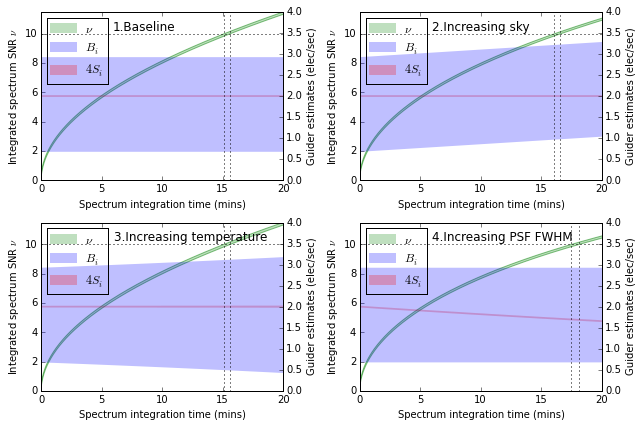

In [38]:
def projection_grid(n=20*60,save=None):
    #
    dbg0 = 1.8
    dsig0 = 0.5
    #
    nominal_area = 1e4 # pixels
    nominal_sky_level = 21.8 # elec/sec/pixel
    nominal_temp_C = 20.0 # degC
    temp_error = 1.0 # degC RMS
    nominal_snr = 100. # total SNR for all guide stars in one guide exposure
    nominal_fwhm = 1.2 # arcsecs
    nominal_bg_tot = gfa_total_bg(temperature_C=nominal_temp_C,sky_brightness=nominal_sky_level)
    #
    t = np.arange(1,n+1)
    baseline_bg_frac = bg_error_fraction(area_pixels=nominal_area,temperature_C=nominal_temp_C,
                                         temperature_error=temp_error,sky_brightness=nominal_sky_level)
    baseline_sig_frac = gaussian_error_fraction(nominal_snr,nominal_fwhm)
    #
    ramp = np.linspace(0.,1.,n)
    #
    # Increase the sky brightness by 20% during the exposure, which increases Bi and dSi.
    new_sky = nominal_sky_level*(1+0.2*ramp)
    sky_bg_frac = bg_error_fraction(area_pixels=nominal_area,temperature_C=nominal_temp_C,
                                    temperature_error=temp_error,sky_brightness=new_sky)
    sky_dbg = dbg0*new_sky/nominal_sky_level
    sky_bg_tot = gfa_total_bg(temperature_C=nominal_temp_C,sky_brightness=new_sky)    
    sky_sig_frac = gaussian_error_fraction(nominal_snr*np.sqrt(nominal_bg_tot/sky_bg_tot),nominal_fwhm)
    # Increase the GFA temperature by 5C during the exposure, which increases dBi, and dSi.
    new_temp = nominal_temp_C + 5*ramp
    temp_bg_frac = bg_error_fraction(area_pixels=nominal_area,temperature_C=new_temp,
                                     temperature_error=temp_error,sky_brightness=new_sky)
    temp_bg_tot = gfa_total_bg(temperature_C=new_temp,sky_brightness=nominal_sky_level)
    temp_sig_frac = gaussian_error_fraction(nominal_snr*np.sqrt(nominal_bg_tot/temp_bg_tot),nominal_fwhm)
    # Increase the FHWM from 1.2 to 1.4 during the exposure, which decreases Si and increases dSi.
    new_fwhm = nominal_fwhm + 0.2*ramp
    fwhm_sig_frac = gaussian_error_fraction(nominal_snr*(nominal_fwhm/new_fwhm),new_fwhm)
    fwhm_dsig = gaussian_fiber_acceptance(new_fwhm)/gaussian_fiber_acceptance(nominal_fwhm)*dsig0
    # Could also decrease the atmospheric transparency by 20%, which decreases Si and increases dSi.
    #
    sb_lim = (0,4)
    plt.figure(figsize=(9,6))
    plt.subplot(2,2,1)
    projection_plot(t,dsig=dsig0,dbg=dbg0,sig_error_frac=baseline_sig_frac,bg_error_frac=baseline_bg_frac,sb_lim=sb_lim,
                    label='1.Baseline')
    plt.subplot(2,2,2)
    projection_plot(t,dsig=dsig0,dbg=sky_dbg,sig_error_frac=sky_sig_frac,bg_error_frac=sky_bg_frac,sb_lim=sb_lim,
                    label='2.Increasing sky')
    plt.subplot(2,2,3)
    projection_plot(t,dsig=dsig0,dbg=dbg0,sig_error_frac=temp_sig_frac,bg_error_frac=temp_bg_frac,sb_lim=sb_lim,
                    label='3.Increasing temperature')
    plt.subplot(2,2,4)
    projection_plot(t,dsig=fwhm_dsig,dbg=dbg0,sig_error_frac=fwhm_sig_frac,bg_error_frac=baseline_bg_frac,sb_lim=sb_lim,
                    label='4.Increasing PSF FWHM')
    plt.tight_layout()
    if save:
        plt.savefig(save)
projection_grid()#save='project.pdf')

SNR0 = 10.0 reached after 14.0-16.8 minutes (167.3 sec window)
SNR0 = 10.0 reached after 14.2-16.6 minutes (147.5 sec window)


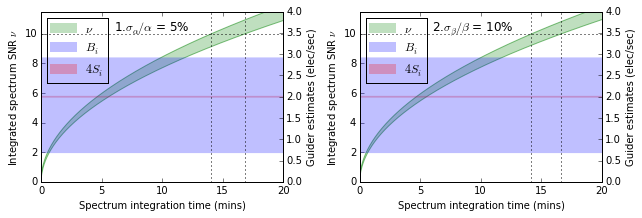

In [39]:
def calib_plot(n=20*60,save=None):
    #
    dbg0 = 1.8
    dsig0 = 0.5
    #
    nominal_area = 1e4 # pixels
    nominal_sky_level = 21.8 # elec/sec/pixel
    nominal_temp_C = 20.0 # degC
    temp_error = 1.0 # degC RMS
    nominal_snr = 100. # total SNR for all guide stars in one guide exposure
    nominal_fwhm = 1.2 # arcsecs
    nominal_bg_tot = gfa_total_bg(temperature_C=nominal_temp_C,sky_brightness=nominal_sky_level)
    #
    t = np.arange(1,n+1)
    baseline_bg_frac = bg_error_fraction(area_pixels=nominal_area,temperature_C=nominal_temp_C,
                                         temperature_error=temp_error,sky_brightness=nominal_sky_level)
    baseline_sig_frac = gaussian_error_fraction(nominal_snr,nominal_fwhm)
    #
    sb_lim = (0,4)
    plt.figure(figsize=(9,3.1))
    plt.subplot(1,2,1)
    projection_plot(t,dsig=dsig0,dbg=dbg0,sig_error_frac=baseline_sig_frac,bg_error_frac=baseline_bg_frac,sb_lim=sb_lim,
                    label='1.$\sigma_{\\alpha}/\\alpha$ = 5%',alpha_rel_error=0.05)
    plt.subplot(1,2,2)
    projection_plot(t,dsig=dsig0,dbg=dbg0,sig_error_frac=baseline_sig_frac,bg_error_frac=baseline_bg_frac,sb_lim=sb_lim,
                    label='2.$\sigma_{\\beta}/\\beta$ = 10%',beta_rel_error=0.10)
    #
    plt.tight_layout()
    if save:
        plt.savefig(save)
calib_plot()#save='calib_error.pdf')